![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Análisis de sentimientos y técnicas de NLP

En este taller podrán poner en práctica sus conocimientos sobre las diferentes técnicas para el procesamiento de lenguaje natural. El taller está constituido por 5 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción sentimientos de viajeros en Twitter

En este taller se usará el conjunto de datos de sentimientos sobre distintas aerolíneas de EE.UU. provenientes de Twitter. Cada observación contiene si el sentimiento de los tweets es positivo, neutral o negativo teniendo en cuenta distintas variables como aerolínea y las razones de los sentimientos negativos (como "retraso en el vuelo" o "servicio grosero"). El objetivo es predecir el sentimiento asociado a cada tweet. Para más detalles pueden visitar el siguiente enlace: [datos](https://www.kaggle.com/crowdflower/twitter-airline-sentiment).

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
# Lectura de la información de archivo .zip
tweets = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/Tweets.zip', index_col=0)

# Visualización dataset
tweets.head()

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
tweet_id,,,,,,,,,,,,,,
570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
# Impresión tamaño del cojunto de datos
tweets.shape

(14640, 14)

### Análisis descriptivo

In [5]:
# Cuenta de tweets por cada sentimiento
tweets['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [6]:
# Cuenta de tweets por cada aerolínea
tweets['airline'].value_counts()

United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

<AxesSubplot:title={'center':'Sentiminetos por aerolínea'}, xlabel='airline'>

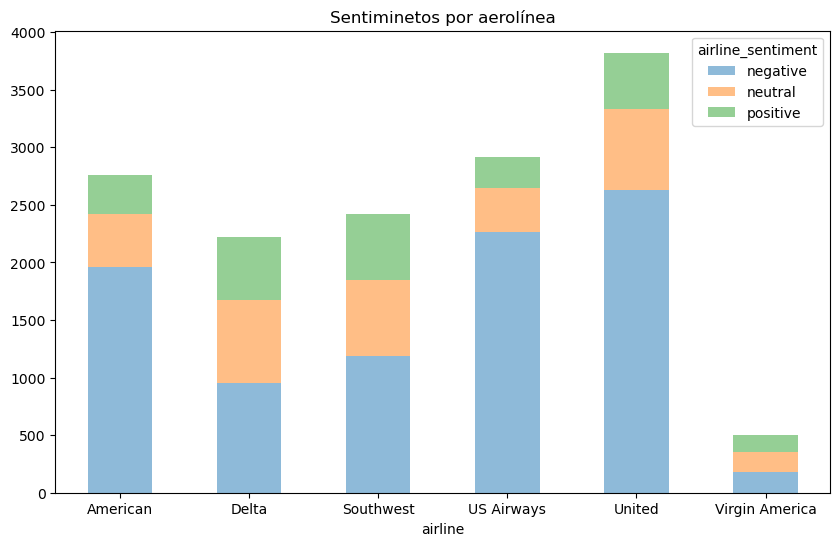

In [7]:
# Plot con cuenta de tweets por cada aerolínea y sentimiento
pd.crosstab(index = tweets["airline"],columns = tweets["airline_sentiment"]).plot(kind='bar',figsize=(10, 6),alpha=0.5,rot=0,stacked=True,title="Sentiminetos por aerolínea")

### Liberias y Variables de interés y predicción

In [8]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from sklearn.metrics import accuracy_score
import time



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jeanv\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jeanv\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\jeanv\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [9]:
# Separación de variables predictoras (X) y de variable de interés (y)
X = tweets['text']
y = tweets['airline_sentiment'].map({'negative':-1,'neutral':0,'positive':1})

In [10]:
# Separación de datos en set de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Uso de CountVectorizer

En la celda 1 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función **CountVectorizer** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [11]:
# Celda 1
#Parte inicial revisión tiempos de ejecución
start_time = time.time()

# Preprocesamiento con CountVectorizer
vectorizer = CountVectorizer(lowercase=True)
X_train_count = vectorizer.fit_transform(X_train)
X_test_count = vectorizer.transform(X_test)

# Creación del modelo de Random Forest Regressor
rf = RandomForestClassifier()

# Entrenamiento del modelo
rf.fit(X_train_count, y_train)

# Predicción sobre el conjunto de test
y_pred_rf = rf.predict(X_test_count)

#Accuracy
accuracy_1 = accuracy_score(y_test, y_pred_rf)
print("Accuracy:", accuracy_1)

#Parte final revisión tiempos de ejecución
end_time = time.time()
duration = end_time - start_time
elapsed_time_minutes = duration / 60

print("Tiempo de ejecución: ", elapsed_time_minutes, "minutos")

Accuracy: 0.7711092715231788
Tiempo de ejecución:  0.14330491224924724 minutos


### Punto 2 - Eliminación de Stopwords

En la celda 2 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función CountVectorizer, **eliminen stopwords** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [12]:
# Celda 2
#Parte inicial revisión tiempos de ejecución
start_time = time.time()

# Preprocesamiento con CountVectorizer

# Conversión de texto a minúsculas y Eliminación de stopwords al usar el parámetro 'stop_words' de la función CountVectorizer()

vect_no_stopw = CountVectorizer(lowercase=True, stop_words='english')
X_train_count = vect_no_stopw.fit_transform(X_train)
X_test_count = vect_no_stopw.transform(X_test)

# Creación del modelo de Random Forest Regressor
rf = RandomForestClassifier()

# Entrenamiento del modelo
rf.fit(X_train_count, y_train)

# Predicción sobre el conjunto de test
y_pred_rf = rf.predict(X_test_count)

#Accuracy
accuracy_2 = accuracy_score(y_test, y_pred_rf)
print("Accuracy:", accuracy_2)

#Parte final revisión tiempos de ejecución
end_time = time.time()
duration = end_time - start_time
elapsed_time_minutes = duration / 60

print("Tiempo de ejecución: ", elapsed_time_minutes, "minutos")

Accuracy: 0.7649006622516556
Tiempo de ejecución:  0.13941011826197305 minutos


### Punto 3 - Lematización con verbos

En la celda 3 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función CountVectorizer, **lematizen el texto con verbos** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [13]:
# Celda 3

#Parte inicial revisión tiempos de ejecución
start_time = time.time()

# Definir el lematizador
lemmatizer = WordNetLemmatizer()
 
# Definir una función para lematizar solo los verbos
def lemmatize_verbs(text):
    tokens = word_tokenize(text)
    lemmatized_tokens = []
    for token in tokens:
        lemma = lemmatizer.lemmatize(token, pos='v')
        lemmatized_tokens.append(lemma)
    return " ".join(lemmatized_tokens)
 
# Lematizar los tweets de entrenamiento
X_train_lemmatized = [lemmatize_verbs(tweet) for tweet in X_train]
 
# Lematizar los tweets de prueba
X_test_lemmatized = [lemmatize_verbs(tweet) for tweet in X_test]
 
# Crear un objeto CountVectorizer y transformar los tweets lematizados de entrenamiento
vectorizer = CountVectorizer(lowercase=True)
X_train_vectorized = vectorizer.fit_transform(X_train_lemmatized)
 
# Transformar los tweets lematizados de prueba usando el mismo objeto CountVectorizer
X_test_vectorized = vectorizer.transform(X_test_lemmatized)
 
# Crear un modelo de Random Forest y ajustarlo a los datos de entrenamiento vectorizados
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_vectorized, y_train)
 
# Predecir las etiquetas para los datos de prueba vectorizados
y_pred = rf.predict(X_test_vectorized)
 
# Calcular el accuracy del modelo
from sklearn.metrics import accuracy_score
accuracy_3 = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy_3)

#Parte final revisión tiempos de ejecución
end_time = time.time()
duration = end_time - start_time
elapsed_time_minutes = duration / 60

print("Tiempo de ejecución: ", elapsed_time_minutes, "minutos")

Accuracy: 0.7758692052980133
Tiempo de ejecución:  0.22267104387283326 minutos


### Punto 4 - Multiples técnicas

En la celda 4 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función **CountVectorizer, eliminen stopwords, lematizen el texto con verbos** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [14]:
# Celda 4

#Parte inicial revisión tiempos de ejecución
start_time = time.time()

# Definir el lematizador
lemmatizer = WordNetLemmatizer()
 
# Definir una función para lematizar solo los verbos
def lemmatize_verbs(text):
    tokens = word_tokenize(text)
    lemmatized_tokens = []
    for token in tokens:
        lemma = lemmatizer.lemmatize(token, pos='v')
        lemmatized_tokens.append(lemma)
    return " ".join(lemmatized_tokens)
 
# Lematizar los tweets de entrenamiento
X_train_lemmatized = [lemmatize_verbs(tweet) for tweet in X_train]
 
# Lematizar los tweets de prueba
X_test_lemmatized = [lemmatize_verbs(tweet) for tweet in X_test]
 
# Crear un objeto CountVectorizer y transformar los tweets lematizados de entrenamiento
vectorizer = CountVectorizer(lowercase=True, stop_words='english')
X_train_vectorized = vectorizer.fit_transform(X_train_lemmatized)
 
# Transformar los tweets lematizados de prueba usando el mismo objeto CountVectorizer
X_test_vectorized = vectorizer.transform(X_test_lemmatized)
 
# Crear un modelo de Random Forest y ajustarlo a los datos de entrenamiento vectorizados
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_vectorized, y_train)
 
# Predecir las etiquetas para los datos de prueba vectorizados
y_pred = rf.predict(X_test_vectorized)
 
# Calcular el accuracy del modelo
from sklearn.metrics import accuracy_score
accuracy_4 = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy_4)

#Parte final revisión tiempos de ejecución
end_time = time.time()
duration = end_time - start_time
elapsed_time_minutes = duration / 60

print("Tiempo de ejecución: ", elapsed_time_minutes, "minutos")

Accuracy: 0.7622102649006622
Tiempo de ejecución:  0.1859456181526184 minutos


### Punto 5 - Comparación y análisis de resultados

En la celda 5 comparen los resultados obtenidos de los diferentes modelos (random forest) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

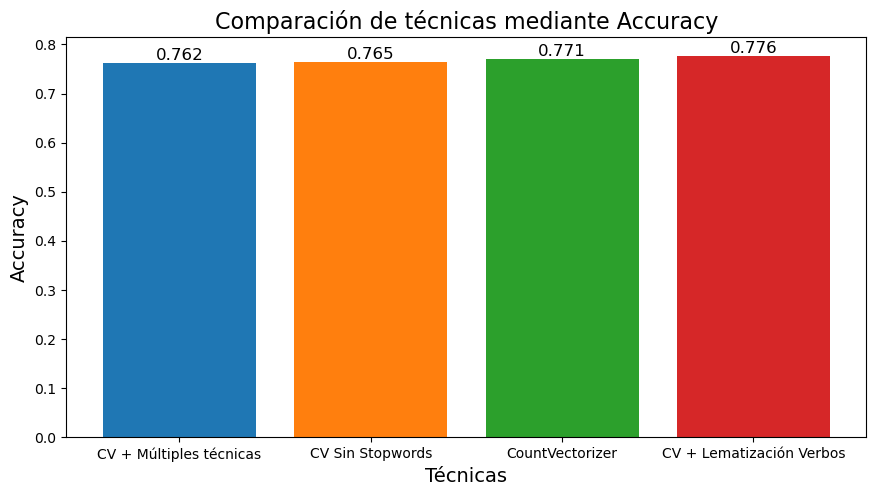

In [20]:
# Celda 5
#Gráficar y comparar Accuracy
 
fig = plt.figure(figsize=(8,4))
ax = fig.add_axes([0,0,1,1])
ax.set_title("Comparación de técnicas mediante Accuracy", fontsize=16)
ax.set_xlabel("Técnicas", fontsize=14)
ax.set_ylabel("Accuracy", fontsize=14)
ejeX = ['CountVectorizer', 'CV Sin Stopwords', 'CV + Lematización Verbos', 'CV + Múltiples técnicas']
ejeY = [accuracy_1, accuracy_2, accuracy_3, accuracy_4]
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
ejeX, ejeY = zip(*sorted(zip(ejeX, ejeY), key=lambda x: x[1]))
ax.bar(ejeX,ejeY, color=colors)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i], round(y[i],3), ha='center', va='bottom', fontsize=12)
addlabels(ejeX,ejeY,ax)
plt.show()

En cuanto al modelo de RandomForest con el **menor desempeño** con **Accuracy de 0.762** en el que se utilizó **CountVectorizer y se combinaron las técnicas de eliminación de stopwords y lematización del texto con verbos**, evidenciamos que no siempre es cierto que eliminar los stopwords mejora el accuracy de un modelo de aprendizaje automático. En algunos casos, los stopwords pueden contener información útil y eliminarlos puede hacer que el modelo pierda información importante. 

Sobre el modelo de RandomForest con el **mayor desempeño** con **Accuracy de 0.776** en el que se utilizó **CountVectorizer y se aplicó Lematización de verbos**: Como ventaja de la lematización de verbos, se destaca que ayuda a reducir la variación morfológica en los datos de entrada, lo que puede mejorar la precisión del modelo y reducir el ruido en los datos. 

A nivel general, se identifica que el desempeño del modelo de RandomForest aplicando las 4 técnicas no presenta diferencia significativa en relación al Accuracy obtenido entre 0.762 y 0.776, con una diferencia de 1.4% entre los modelos de menor y mayor desempeño.
